In [1]:
!pip install 'kaggle-environments>=0.1.6'

In [2]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from kaggle_environments import evaluate, make, utils

# Define Gym Class

In [3]:
import random

def combined_agent(default_agent, alternate_agent, epsilon):
    def updated_agent(obs, config):
        if (random.random() < epsilon):
            return alternate_agent(obs, config)
        return default_agent(obs,config)
    return updated_agent

from kaggle_environments.envs.connectx.connectx import negamax_agent
from kaggle_environments.envs.connectx.connectx import random_agent

e_greedy_negamax = combined_agent(negamax_agent, random_agent, 0.4)

In [4]:
class ConnectX(gym.Env):
    def __init__(self, switch_prob=0.5):
        self.env = make('connectx', debug=False)
        self.pair = [None, e_greedy_negamax]
        self.trainer = self.env.train(self.pair)
        self.switch_prob = switch_prob

        config = self.env.configuration
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Discrete(config.columns
                * config.rows)

    def switch_trainer(self):
        self.pair = self.pair[::-1]
        self.trainer = self.env.train(self.pair)

    def step(self, action):
        return self.trainer.step(action)

    def reset(self):
        if np.random.random() < self.switch_prob:
            self.switch_trainer()
        return self.trainer.reset()

    def render(self, **kwargs):
        return self.env.render(**kwargs)

# Define Model

In [5]:
class DeepModel(nn.Module):
    def __init__(
        self,
        num_states,
        hidden_units,
        num_actions,
        ):
        super(DeepModel, self).__init__()
        self.hidden_layers = nn.ModuleList([])
        for i in range(len(hidden_units)):
            if i == 0:
                self.hidden_layers.append(nn.Linear(num_states,
                        hidden_units[i]))
            else:
                self.hidden_layers.append(nn.Linear(hidden_units[i
                        - 1], hidden_units[i]))
        self.output_layer = nn.Linear(hidden_units[-1], num_actions)

    def forward(self, x):

        for layer in self.hidden_layers:
            x = torch.sigmoid(layer(x))
        x = self.output_layer(x)
        return x


class DoubleDQN:
    def __init__(
        self,
        num_states,
        num_actions,
        hidden_units,
        gamma,
        max_experiences,
        min_experiences,
        batch_size,
        lr,
        target_update_freq
        ):
        self.device = torch.device(('cuda'
                                    if torch.cuda.is_available() else 'cpu'
                                   ))
        print(self.device)
        self.num_actions = num_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.model = DeepModel(num_states, hidden_units,
                               num_actions).to(self.device)
        self.model_target = DeepModel(num_states, hidden_units, num_actions).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.experience = {
            's': [],
            'a': [],
            'r': [],
            's2': [],
            'done': [],
            }
        self.max_experiences = max_experiences
        self.min_experiences = min_experiences
        self.param_update_count = 0
        self.target_update_freq = target_update_freq

    def predict(self, inputs, model):
        return model(torch.from_numpy(inputs).float().to(self.device))

    def train(self, TargetNet):
        if len(self.experience['s']) < self.min_experiences:
            # only start training process if enough experiences in buffer
            return 0

        # randomly select n experiences in buffer to form batch
        ids = np.random.randint(low=0, high=len(self.experience['s']),
                                size=self.batch_size)
        states = np.asarray([self.preprocess(self.experience['s'][i])
                            for i in ids])
        actions = np.asarray([self.experience['a'][i] for i in ids])
        actions = torch.autograd.Variable(torch.from_numpy(actions)).type(torch.LongTensor).to(self.device)
        rewards = np.asarray([self.experience['r'][i] for i in ids])
        rewards = torch.autograd.Variable(torch.from_numpy(rewards)).type(torch.FloatTensor).to(self.device)


        # prepare labels
        states_next = np.asarray([self.preprocess(self.experience['s2'
                                 ][i]) for i in ids])
        dones = np.asarray([self.experience['done'][i] for i in ids])
        dones_mask = torch.autograd.Variable(torch.from_numpy(dones)).type(torch.FloatTensor).to(self.device)
        
        # get Q values for best actions in observation
        q_values = self.predict(states_next, self.model).detach()
        _, a_prime = q_values.max(1)
        
        # get Q values from target network for next state and choise action
        q_target_values = self.predict(states_next, self.model_target).detach()
        q_target_a_prime = q_target_values.gather(1, a_prime.unsqueeze(1))
        q_target_a_prime = q_target_a_prime.squeeze()
        
        # if current state is end of episode, no next Q value
        q_target_a_prime = (1 - dones_mask) * q_target_a_prime
        
        # get q values of current observation
        q_vals = self.predict(states, self.model)
        q_actions = q_vals.gather(1, actions.unsqueeze(1))
        q_actions = q_actions.squeeze()
        
        # compute bellman error
        error = rewards + self.gamma * q_target_a_prime - q_actions
        
        clipped_error = -1.0 * error.clamp(-1,1)
        
        self.optimizer.zero_grad()
        q_actions.backward(clipped_error.data)
        
        self.optimizer.step()
        
        self.param_update_count += 1
        
        if self.param_update_count % self.target_update_freq == 0:
                self.model_target.load_state_dict(self.model.state_dict())

    def get_action(self, state, epsilon):
        # to get an action by using epsilon-greedy
        if np.random.random() < epsilon:
            return int(np.random.choice([c for c in
                       range(self.num_actions) if state['board'][c]
                       == 0]))
        else:
            prediction = \
                self.predict(np.atleast_2d(self.preprocess(state)), self.model)[0].detach().cpu().numpy()
            for i in range(self.num_actions):
                if state['board'][i] != 0:
                    prediction[i] = -1e7
            return int(np.argmax(prediction))

    def add_experience(self, exp):
        if len(self.experience['s']) >= self.max_experiences:
            for key in self.experience.keys():
                self.experience[key].pop(0)
        for (key, value) in exp.items():
            self.experience[key].append(value)

    def copy_weights(self, TrainNet):
        self.model.load_state_dict(TrainNet.model.state_dict())

    def save_weights(self, path):
        torch.save(self.model.state_dict(), path)

    def load_weights(self, path):
        self.model.load_state_dict(torch.load(path))

    def preprocess(self, state):
        # each state consists of overview of the board and the mark in the obsevations
        results = (state['board'])[:]
        results.append(state.mark)
        return results

In [6]:
def play_game(
    env,
    TrainNet,
    TargetNet,
    epsilon,
    copy_step,
    ):
    rewards = 0
    iter = 0
    done = False
    observations = env.reset()
    while not done:
        action = TrainNet.get_action(observations, epsilon)
        prev_observations = observations
        (observations, reward, done, _) = env.step(action)

        if done:
            if reward == 1:
                reward = 20
            elif reward == 0:
                reward = -20
            else:
                reward = 10
        else:
            reward = 0.5

        rewards += reward

        exp = {
            's': prev_observations,
            'a': action,
            'r': reward,
            's2': observations,
            'done': done,
            }
        
        TrainNet.add_experience(exp)
        TrainNet.train(TargetNet)
        
        iter += 1
        if iter % copy_step == 0:
            TargetNet.copy_weights(TrainNet)
    return rewards

# Training

In [7]:
gamma = 0.99
copy_step = 1000
hidden_units = [128, 128, 128, 128, 128]
max_experiences = 10000
min_experiences = 100
batch_size = 32
lr = 1e-2
epsilon = 0.999
decay = 0.9999
min_epsilon = 0.01
episodes = 50000
target_update_freq = 1000

precision = 7

In [8]:
env = ConnectX()

num_states = env.observation_space.n + 1
num_actions = env.action_space.n

all_total_rewards = np.empty(episodes)
all_avg_rewards = np.empty(episodes) # Last 100 steps
all_epsilons = np.empty(episodes)

# Initialize models
TrainNet = DoubleDQN(num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr, target_update_freq)
TargetNet = DoubleDQN(num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr, target_update_freq)

cuda
cuda


In [ ]:
from tqdm.notebook import tqdm

for n in tqdm(range(episodes)):
    epsilon = max(min_epsilon, epsilon * decay)
    total_reward = play_game(env, TrainNet, TargetNet, epsilon, copy_step)
    all_total_rewards[n] = total_reward
    avg_reward = all_total_rewards[max(0, n - 100):(n + 1)].mean()
    all_avg_rewards[n] = avg_reward
    all_epsilons[n] = epsilon

    if n % 1000 == 0:
        print('[{}/{}] episode_reward: {:.3f}, avg_reward: {:.3f}, epsilon: {:.5f}'.format(n,episodes,total_reward, avg_reward, epsilon))

[0/50000] episode_reward: 17.500, avg_reward: 17.500, epsilon: 0.99890
[1000/50000] episode_reward: 14.000, avg_reward: 15.708, epsilon: 0.90384
[2000/50000] episode_reward: 12.000, avg_reward: 15.946, epsilon: 0.81782
[3000/50000] episode_reward: 14.500, avg_reward: 16.000, epsilon: 0.73999
[4000/50000] episode_reward: 11.500, avg_reward: 15.173, epsilon: 0.66957
[5000/50000] episode_reward: 26.500, avg_reward: 15.718, epsilon: 0.60585
[6000/50000] episode_reward: 22.500, avg_reward: 14.832, epsilon: 0.54819
[7000/50000] episode_reward: 27.500, avg_reward: 15.683, epsilon: 0.49602
[8000/50000] episode_reward: 13.000, avg_reward: 15.480, epsilon: 0.44882
[9000/50000] episode_reward: 16.000, avg_reward: 15.134, epsilon: 0.40610
[10000/50000] episode_reward: 13.500, avg_reward: 15.837, epsilon: 0.36746
[11000/50000] episode_reward: 13.000, avg_reward: 15.723, epsilon: 0.33249
[12000/50000] episode_reward: 11.500, avg_reward: 15.381, epsilon: 0.30084
[13000/50000] episode_reward: 24.000, 

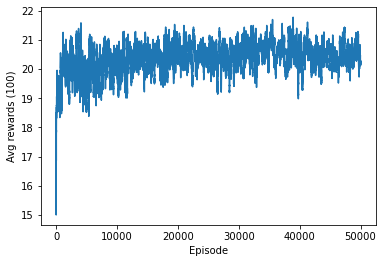

In [9]:
plt.plot(all_avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Avg rewards (100)')
plt.show()

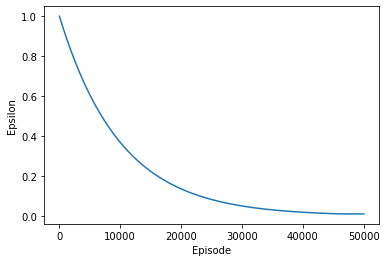

In [10]:
plt.plot(all_epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

In [11]:
TrainNet.save_weights('./weights-doubleq.pth')

# Create Agent

In [12]:
fc_layers = []

# Get all hidden layers' weights
for i in range(len(hidden_units)):
    fc_layers.extend([
        TrainNet.model.hidden_layers[i].weight.T.tolist(), # weights
        TrainNet.model.hidden_layers[i].bias.tolist() # bias
    ])

# Get output layer's weights
fc_layers.extend([
    TrainNet.model.output_layer.weight.T.tolist(), # weights
    TrainNet.model.output_layer.bias.tolist() # bias
])

# Convert all layers into usable form before integrating to final agent
fc_layers = list(map(
    lambda x: str(list(np.round(x, precision))) \
        .replace('array(', '').replace(')', '') \
        .replace(' ', '') \
        .replace('\n', ''),
    fc_layers
))
fc_layers = np.reshape(fc_layers, (-1, 2))

# Create the agent
my_agent = '''def my_agent(observation, configuration):
    import numpy as np

'''

# Write hidden layers
for i, (w, b) in enumerate(fc_layers[:-1]):
    my_agent += '    hl{}_w = np.array({}, dtype=np.float32)\n'.format(i+1, w)
    my_agent += '    hl{}_b = np.array({}, dtype=np.float32)\n'.format(i+1, b)
# Write output layer
my_agent += '    ol_w = np.array({}, dtype=np.float32)\n'.format(fc_layers[-1][0])
my_agent += '    ol_b = np.array({}, dtype=np.float32)\n'.format(fc_layers[-1][1])

my_agent += '''
    state = observation.board[:]
    state.append(observation.mark)
    out = np.array(state, dtype=np.float32)

'''

# Calculate hidden layers
for i in range(len(fc_layers[:-1])):
    my_agent += '    out = np.matmul(out, hl{0}_w) + hl{0}_b\n'.format(i+1)
    my_agent += '    out = 1/(1 + np.exp(-out))\n' # Sigmoid function
# Calculate output layer
my_agent += '    out = np.matmul(out, ol_w) + ol_b\n'

my_agent += '''
    for i in range(configuration.columns):
        if observation.board[i] != 0:
            out[i] = -1e7

    return int(np.argmax(out))
    '''


In [13]:
with open('submission-doubleq.py', 'w') as f:
    f.write(my_agent)

In [14]:
from submission import my_agent

In [15]:
def mean_reward(rewards):
    return np.round(rewards.count([1,-1])/len(rewards),2)

print("My Agent vs. Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=10)))
print("My Agent vs. Negamax Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=10)))
print("Random Agent vs. My Agent:", mean_reward(evaluate("connectx", ["random", my_agent], num_episodes=10)))
print("Negamax Agent vs. My Agent:", mean_reward(evaluate("connectx", ["negamax", my_agent], num_episodes=10)))

My Agent vs. Random Agent: 0.7
My Agent vs. Negamax Agent: 0.0
Random Agent vs. My Agent: 0.0
Negamax Agent vs. My Agent: 1.0


In [16]:
print("Negamax Agent vs. Negamax Agent:", mean_reward(evaluate("connectx", ["negamax", "negamax"], num_episodes=10)))

Negamax Agent vs. Negamax Agent: 0.3


In [9]:
def my_agent(observation, configuration):
    return TrainNet.get_action(observation, 0)

In [11]:
def mean_reward(rewards):
    return np.round(rewards.count([1,-1])/len(rewards),2)

from nega_agents import return_nega
negamax_agent1 = return_nega(1)
negamax_agent2 = return_nega(2)
negamax_agent3 = return_nega(3)

print("My Agent vs. Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=100)))
print("My Agent vs. Negamax1 Agent:", mean_reward(evaluate("connectx", [my_agent, negamax_agent1], num_episodes=100)))
print("My Agent vs. Negamax2 Agent:", mean_reward(evaluate("connectx", [my_agent, negamax_agent2], num_episodes=100)))
print("My Agent vs. Negamax3 Agent:", mean_reward(evaluate("connectx", [my_agent, negamax_agent3], num_episodes=100)))
print("My Agent vs. Negamax4 Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=100)))
print("Random Agent vs. My Agent:", mean_reward(evaluate("connectx", ["random", my_agent], num_episodes=100)))
print("Negamax1 Agent vs. My Agent:", mean_reward(evaluate("connectx", [negamax_agent1, my_agent], num_episodes=100)))
print("Negamax2 Agent vs. My Agent:", mean_reward(evaluate("connectx", [negamax_agent2, my_agent], num_episodes=100)))
print("Negamax3 Agent vs. My Agent:", mean_reward(evaluate("connectx", [negamax_agent3, my_agent], num_episodes=100)))
print("Negamax4 Agent vs. My Agent:", mean_reward(evaluate("connectx", ["negamax", my_agent], num_episodes=100)))

My Agent vs. Random Agent: 0.89
My Agent vs. Negamax1 Agent: 0.95
My Agent vs. Negamax2 Agent: 0.21
My Agent vs. Negamax3 Agent: 0.82
My Agent vs. Negamax4 Agent: 0.0
Random Agent vs. My Agent: 0.17
Negamax1 Agent vs. My Agent: 0.27
Negamax2 Agent vs. My Agent: 0.9
Negamax3 Agent vs. My Agent: 0.36
Negamax4 Agent vs. My Agent: 1.0
